# Time series analysis - Example code 21: State space model of an AR(1) process with unknown a1 parameter

**Lund University, Lund, Sweden**

See also examples 8.3 and 8.9.

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')

from tsa_lth.analysis import plotACFnPACF
from tsa_lth.tests import whiteness_test, check_if_normal

## Simulate an AR(1) process

In [2]:
# Simulate an AR(1) process.
np.random.seed(1)                                   # Set the seed (just done for the lecture!)
N  = 500
A0_start = -0.95
A0_stop  = -0.45
A1 = np.linspace(A0_start, A0_start, N)
#A1[N//2:] = A0_stop                                # Abruptly change a_1.
y = np.zeros(N)
e = np.random.randn(N)
for k in range(1, N):                               # Implement filter by hand to allow a1 to change.
    y[k] = e[k] - A1[k]*y[k-1]

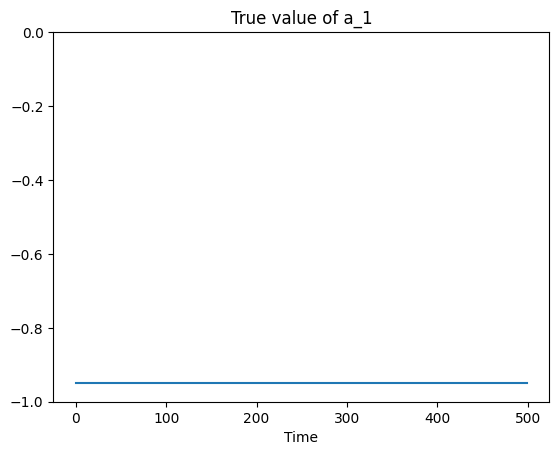

In [3]:
# Show the a_1 value over time.
plt.figure()
plt.plot(A1)
plt.title('True value of a_1')
plt.xlabel('Time')
plt.ylim([-1, 0])
plt.show()

## Set the state as the "unknown" parameter a1 (for now, treated as known)

In [4]:
# Set the state as the "unknown" parameter a1 (for now, treated as known).
A  = 1
B  = 1
xt = A0_start
ys = np.zeros(N)
for t in range(1, N):
    C     = np.array([[-y[t-1]]])                   # The C matrix is now time-varying.
    xt    = A*xt
    ys[t] = C[0, 0]*xt + e[t]

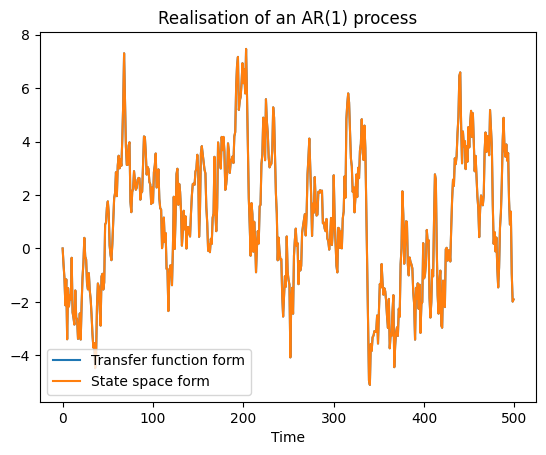

In [5]:
plt.figure()
plt.plot(y, label='Transfer function form')
plt.plot(ys, label='State space form')
plt.title('Realisation of an AR(1) process')
plt.xlabel('Time')
plt.legend(loc='lower left')
plt.show()

## What if we do not know a1?

In [6]:
# Construct a Kalman filter to estimate a_1 (see theorem 8.7). Try
# modifying Re and Rw to see how these affect the estimate (make large 
# changes). Also try different initial covariance matrices - what does it
# mean if you select this "small" or "large"?
Rw    = 1e-1                                        # Measurement noise covariance matrix, R_w
Re    = 1e-6                                        # System noise covariance matrix, R_e
Rx_t1 = np.array([[1.0]])                           # Initial covariance matrix, R_{1|0}^{x,x}
xt    = np.zeros((1, N))                            # Estimated states. Initial state, x_{1|0} = 0.
yhat  = np.zeros(N)                                 # Estimated output.
for t in range(1, N):                               # We use t-1, so start at t=1 .
    # Update the predicted state and the time-varying state vector.
    x_t1 = A*xt[:, t-1]                             # x_{t|t-1} = A x_{t-1|t-1}
    C    = np.array([[-y[t-1]]])
    
    # Update the parameter estimates.
    Ry = C @ Rx_t1 @ C.T + Rw                       # R_{t|t-1}^{y,y} = C R_{t|t-1}^{x,x} + Rw
    Kt = Rx_t1 @ C.T / Ry                           # K_t = R^{x,x}_{t|t-1} C^T inv( R_{t|t-1}^{y,y} )
    yhat[t] = (C @ x_t1)[0]                         # \hat{y}_{t|t-1} = Cx_{t|t-1}
    xt[:, t] = x_t1 + Kt[:, 0] * (y[t] - yhat[t])   # x_{t|t}= x_{t|t-1} + K_t ( y_t - \hat{y}_{t|t-1} )

    # Update the covariance matrix estimates.
    Rx_t  = Rx_t1 - Kt @ Ry @ Kt.T                  # R^{x,x}_{t|t} = R^{x,x}_{t|t-1} - K_t R_{t|t-1}^{y,y} K_t^T
    Rx_t1 = A * Rx_t * A + Re                       # R^{x,x}_{t+1|t} = A R^{x,x}_{t|t} A^T + Re

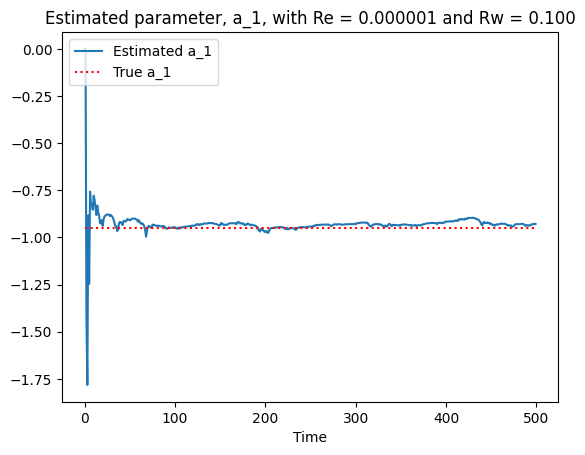

In [7]:
# Show the estimated a1 parameter.
plt.figure()
plt.plot(xt[0, :], label='Estimated a_1')
plt.plot([0, N//2], [A0_start, A0_start], 'r:', label='True a_1')
plt.plot([N//2, N//2+1], [A0_start, A1[N//2+1]], 'r:')
plt.plot([N//2+1, N-1], [A1[N//2+1], A1[N//2+1]], 'r:')
plt.title(f'Estimated parameter, a_1, with Re = {Re:.6f} and Rw = {Rw:.3f}')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.show()

## Show the one-step prediction

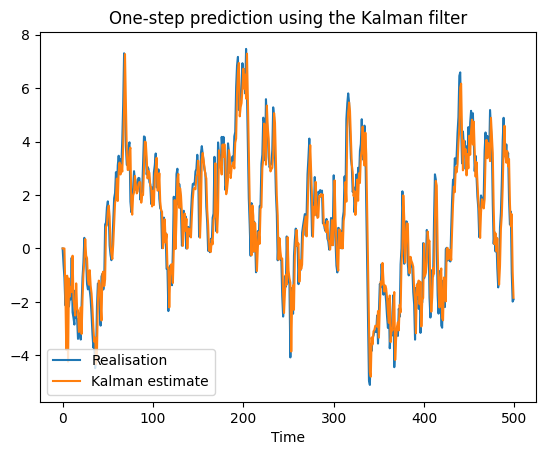

In [8]:
# Show the one-step prediction.
plt.figure()
plt.plot(y, label='Realisation')
plt.plot(yhat, label='Kalman estimate')
plt.title('One-step prediction using the Kalman filter')
plt.xlabel('Time')
plt.legend(loc='lower left')
plt.show()

## How good is this prediction?

In [9]:
# How good is this prediction?
ey = y - yhat
ey = ey[99:]                                        # Ignore the initial values to let the filter converge first.
whiteness_test(ey)

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 15.15 < 37.65)
  McLeod-Li test:        True (white if 25.25 < 37.65)
  Monti test:            True (white if 15.96 < 37.65)
  Sign change test:      True (white if 0.52 in [0.45,0.55])


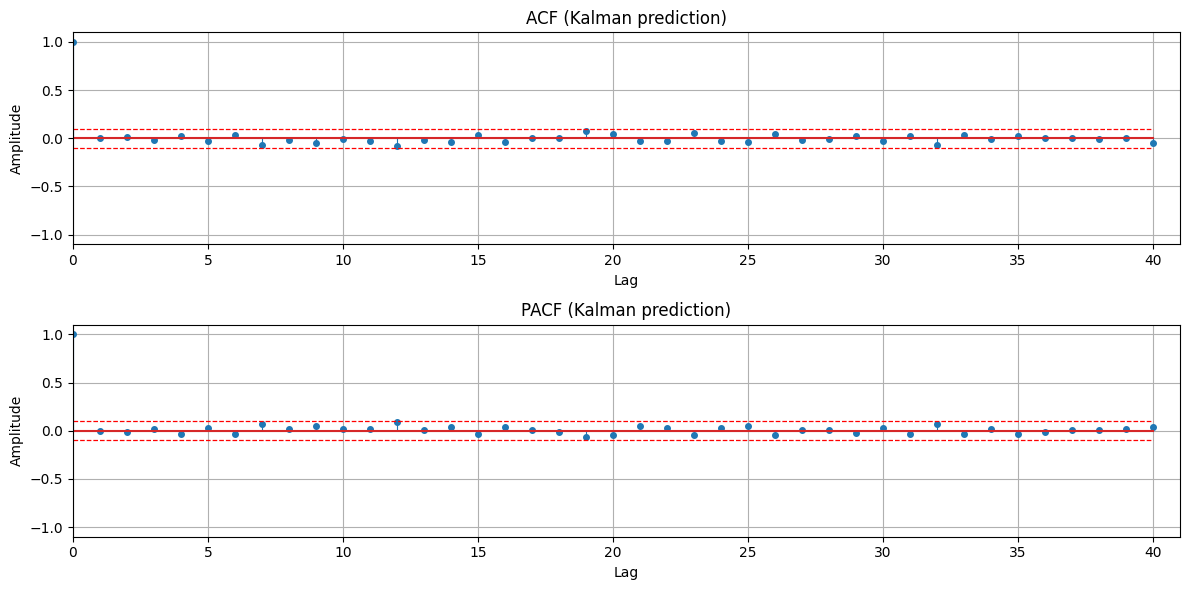

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


In [10]:
acfEst, pacfEst = plotACFnPACF(ey, 40, 'Kalman prediction', return_val=True)
check_if_normal(pacfEst[1:], which_test='D', alpha=0.05)